In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Read in dataset
df = pd.read_csv("https://raw.githubusercontent.com/JosephLazarus/QTW/main/Case%20Study%202/Data/diabetic_data.csv")
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## EDA

In [3]:
df.shape

(101766, 50)

In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
encounter_id,101766.0,1.652016e+08,1.026403e+08,12522.0,84961194.0,152388987.0,2.302709e+08,443867222.0
patient_nbr,101766.0,5.433040e+07,3.869636e+07,135.0,23413221.0,45505143.0,8.754595e+07,189502619.0
admission_type_id,101766.0,2.024006e+00,1.445403e+00,1.0,1.0,1.0,3.000000e+00,8.0
discharge_disposition_id,101766.0,3.715642e+00,5.280166e+00,1.0,1.0,1.0,4.000000e+00,28.0
admission_source_id,101766.0,5.754437e+00,4.064081e+00,1.0,1.0,7.0,7.000000e+00,25.0
time_in_hospital,101766.0,4.395987e+00,2.985108e+00,1.0,2.0,4.0,6.000000e+00,14.0
num_lab_procedures,101766.0,4.309564e+01,1.967436e+01,1.0,31.0,44.0,5.700000e+01,132.0
num_procedures,101766.0,1.339730e+00,1.705807e+00,0.0,0.0,1.0,2.000000e+00,6.0
num_medications,101766.0,1.602184e+01,8.127566e+00,1.0,10.0,15.0,2.000000e+01,81.0
number_outpatient,101766.0,3.693572e-01,1.267265e+00,0.0,0.0,0.0,0.000000e+00,42.0


In [5]:
df_object = df.select_dtypes(include=['object_'])
df_object.describe().transpose()

,count,unique,top,freq
race,101766,6,Caucasian,76099
gender,101766,3,Female,54708
age,101766,10,[70-80),26068
weight,101766,10,?,98569
payer_code,101766,18,?,40256
medical_specialty,101766,73,?,49949
diag_1,101766,717,428,6862
diag_2,101766,749,276,6752
diag_3,101766,790,250,11555
max_glu_serum,101766,4,None,96420


The dataset has a total of 101,766 records with 49 variables with the target variables named 'readmitted'.  Two of those 49 variables are identifiers.

Use the code below to see unique values with their count in each column.
*The team commented the code out because long length of the output.* 

In [6]:
# for col in df:
#     print(col)
#     print(df[col].value_counts())

### Missing Values and Data Imputations
Seems like all missing values have been coded as '?'.  Let's replace all '?' with Nan then count missing value in all columns.

In [7]:
# Replace '?' with Nan
df = df.replace('?', np.NAN)

# Count missing values
df_na = pd.DataFrame(df.isna().sum())
df_na.rename(columns={df_na.columns[0]: 'count'}, inplace = True)

df_na = df_na[df_na['count'] != 0]
df_na['percent_missing'] = df_na['count']/df.shape[0]
df_na = df_na.sort_values('count', ascending=False)

df_na

,count,percent_missing
weight,98569,0.968585
medical_specialty,49949,0.490822
payer_code,40256,0.395574
race,2273,0.022336
diag_3,1423,0.013983
diag_2,358,0.003518
diag_1,21,0.000206


Seven variables have missing values as shown in the table above.
- **weight** has 98,569 missing values, which equal to about 97% missing.
- **medical_specialty** has about 49% missing values.
- **payer_code** has about 40% missing value.
- **race** and **diag_3** have alittle above 2% and 1% missing values, respectively.
- **diag_2** and **diag_1** have less than 1% missing values. 

Run Pearson Correlations to see if other columns have stronf correlation with these 7 variables and can be helpful to fill in missing values.

In [8]:
df_corr = df.apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
df_corr = df_corr[['weight', 'medical_specialty', 'payer_code', 'race', 'diag_3', 'diag_2', 'diag_1']]
df_corr = df_corr.abs()
df_corr.style.background_gradient(cmap='Blues')

,weight,medical_specialty,payer_code,race,diag_3,diag_2,diag_1
encounter_id,0.009245,0.013884,0.369888,0.028370,0.068818,0.109559,0.040695
patient_nbr,0.003434,0.018978,0.364582,0.026747,0.070654,0.111112,0.049278
race,0.054619,0.002744,0.012574,1.000000,0.003335,0.004511,0.017456
gender,0.010623,0.014953,0.034695,0.033583,0.016728,0.008582,0.015656
age,0.007005,0.046885,0.180412,0.140272,0.058892,0.062124,0.059949
weight,1.000000,0.038246,0.032643,0.054619,0.020492,0.033069,0.002529
admission_type_id,0.030567,0.185197,0.044007,0.053243,0.011195,0.015855,0.031607
discharge_disposition_id,0.028147,0.023658,0.090389,0.001661,0.006814,0.003328,0.012434
admission_source_id,0.036410,0.073742,0.124068,0.038691,0.008837,0.028280,0.012768
time_in_hospital,0.019221,0.003048,0.058149,0.005376,0.017085,0.023193,0.005379


#### **weight**
From the correlation table above, **weight** does not seem to have strong correlation with any other columns.  With 97% missing values, we decided to drop weight variable from the dataset due to unreliability. 

In [9]:
df_impute = df

df_impute.drop(columns=['weight'], axis=1, inplace=True)

#### **medical_specialty**
**medical_specialty** has the strongest correlation with admission_type_id.  Let's look at the correlation between each value of **medical_specialty** with admission_type_is to see if admission_type_id can be helpful for missing value imputating for the column.

<AxesSubplot:>

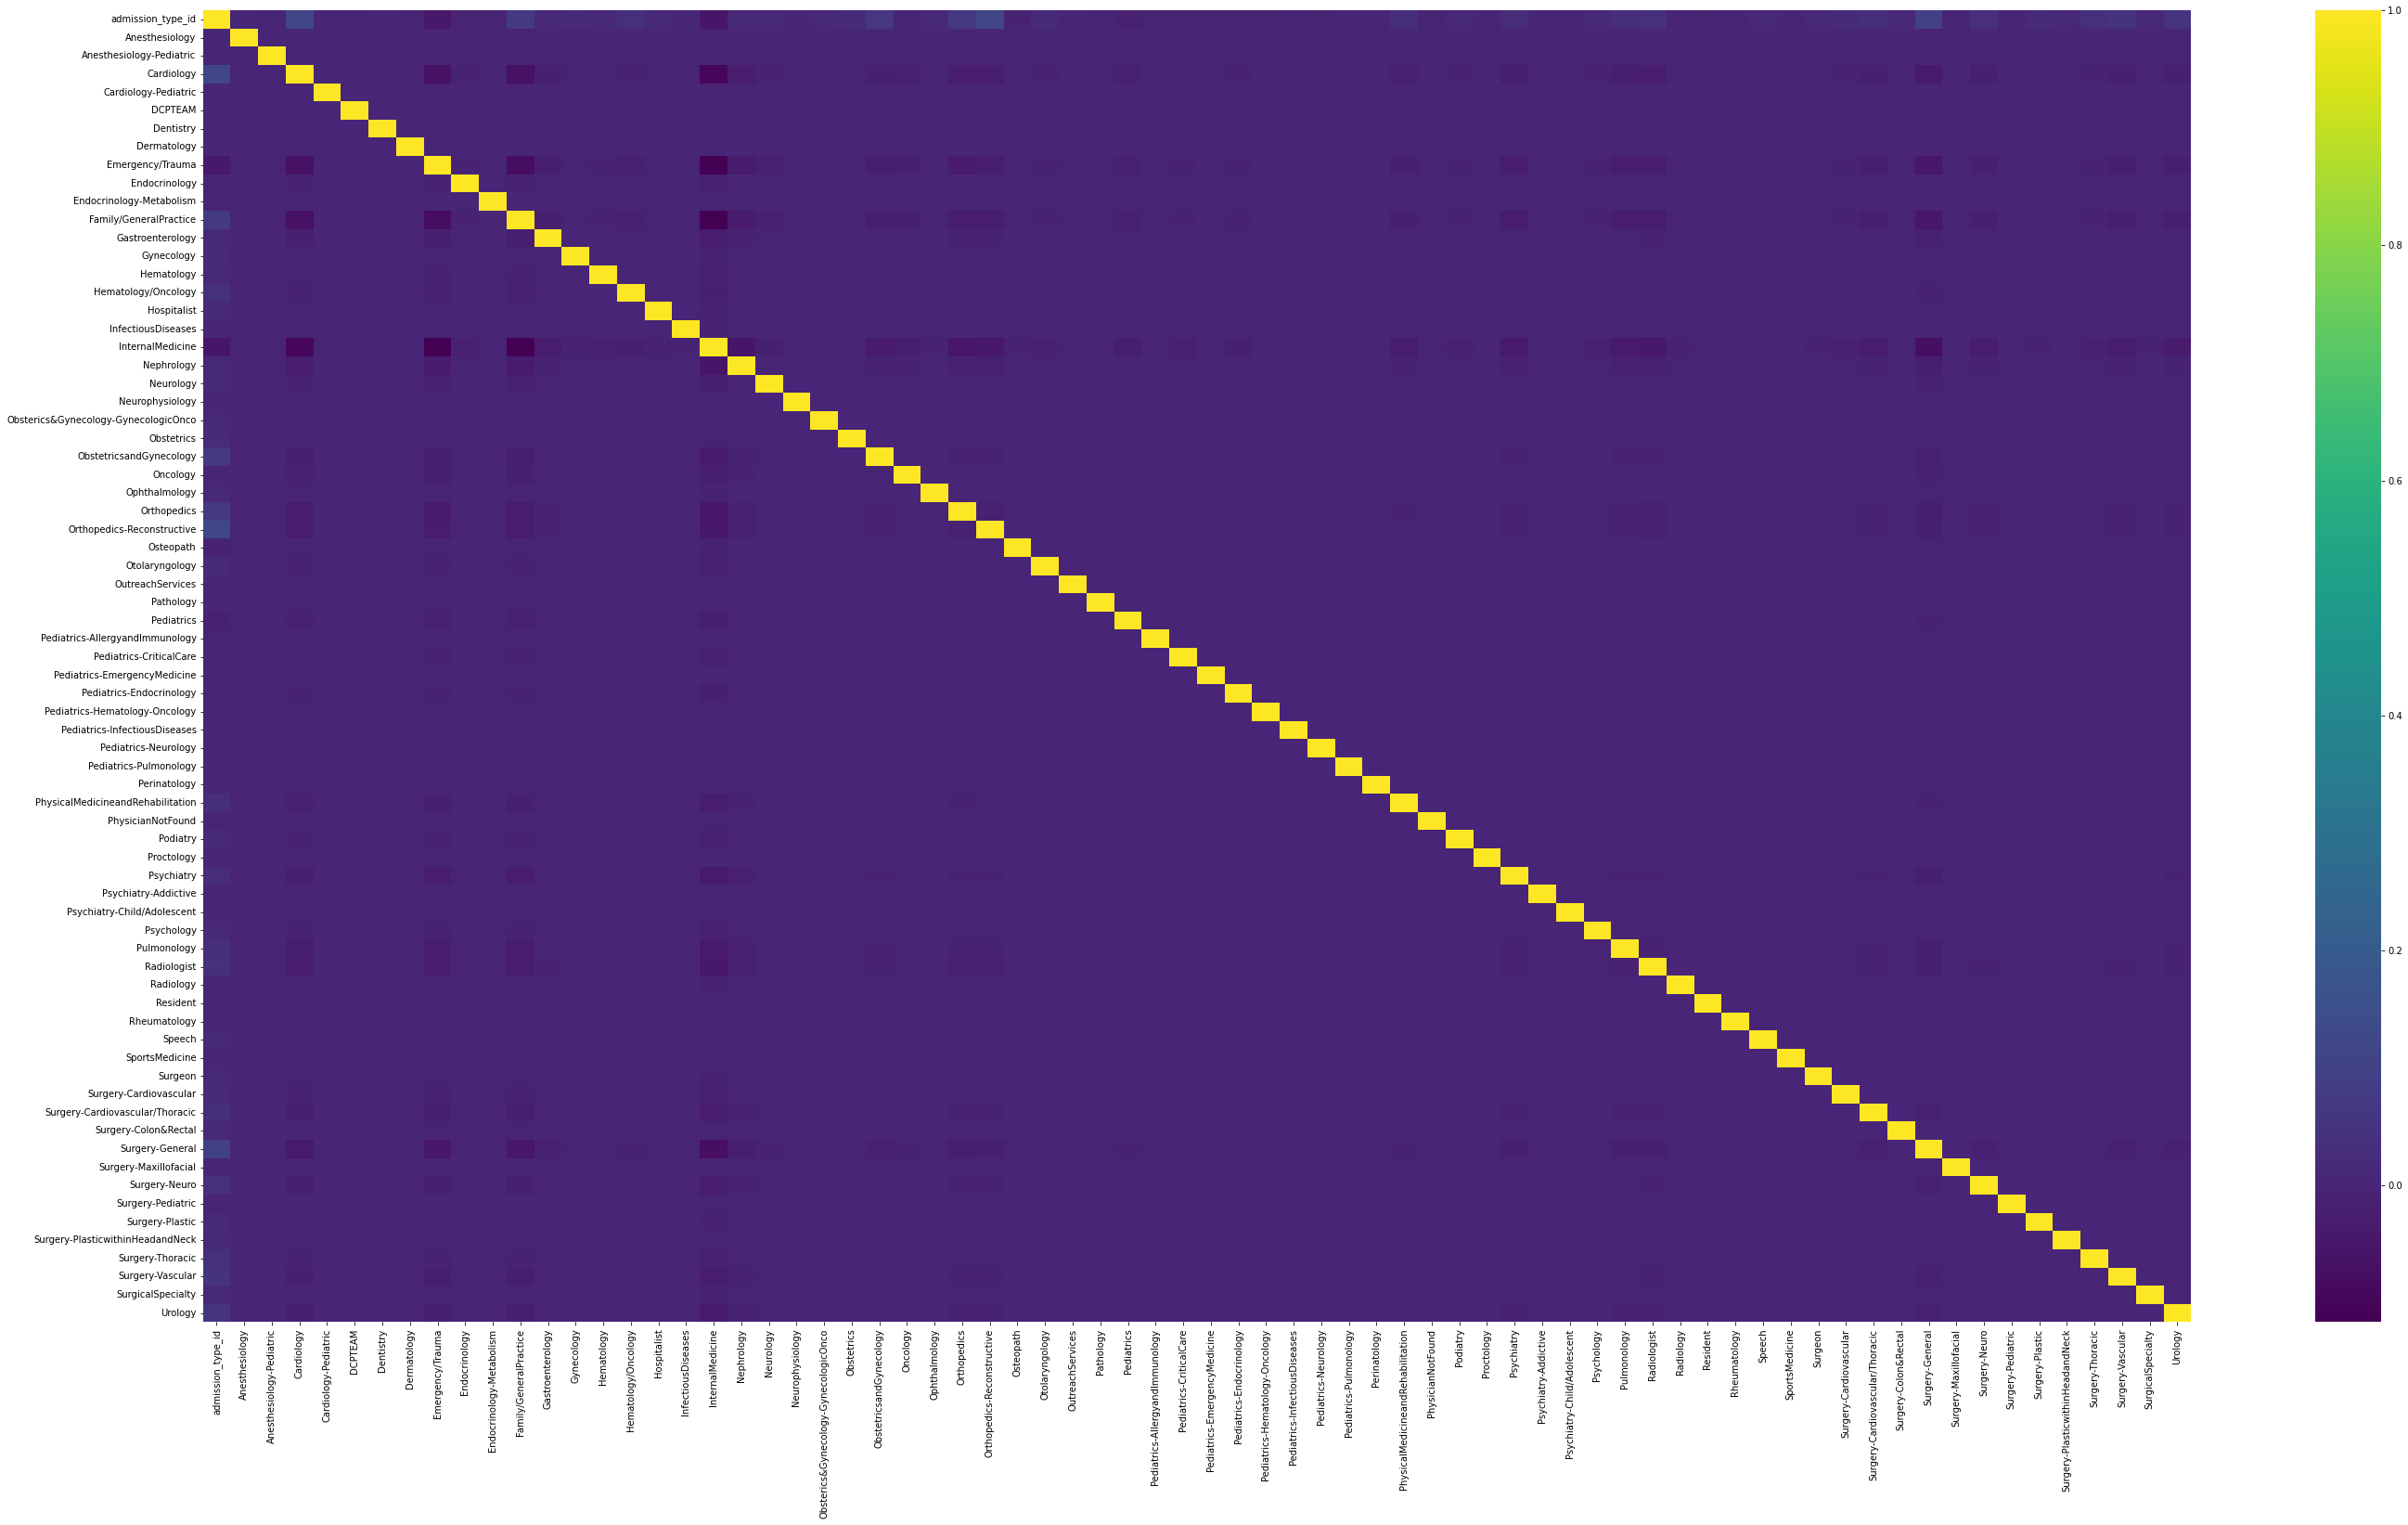

In [10]:
med_spec = df[['medical_specialty', 'admission_type_id']]

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(med_spec['medical_specialty'],drop_first=True)

#dropping original columns
med_spec_df = med_spec.drop('medical_specialty',axis=1)

#concating dummies to the data frame
med_spec_df = pd.concat([med_spec_df, dummies],axis=1)

plt.figure(figsize=(48,26))
sns.heatmap(med_spec_df.corr(), annot=False, cmap='viridis')

With all 73 different values (including missing value) within **medical_specialty**, there is no stong correlation with admission_type_id.  The team decided to fill the **medical_specialty** with 'NA' to preserve the existing values.

In [11]:
df_impute.medical_specialty = df_impute.medical_specialty.fillna('NA')

#### **payer_code**

First, let look at the count for all exists values in the column.

In [12]:
print(df['payer_code'].value_counts())

MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64


Without considering encounter_id and patient_nbr, which are unique identifiers for each patient, **payer_code** has the strongest correlation at 0.180 with age. Let's look at the correlation between each value of **payer_code** with age to see if age can be helpful for missing value imputating for the column.

<AxesSubplot:xlabel='age', ylabel='payer_code'>

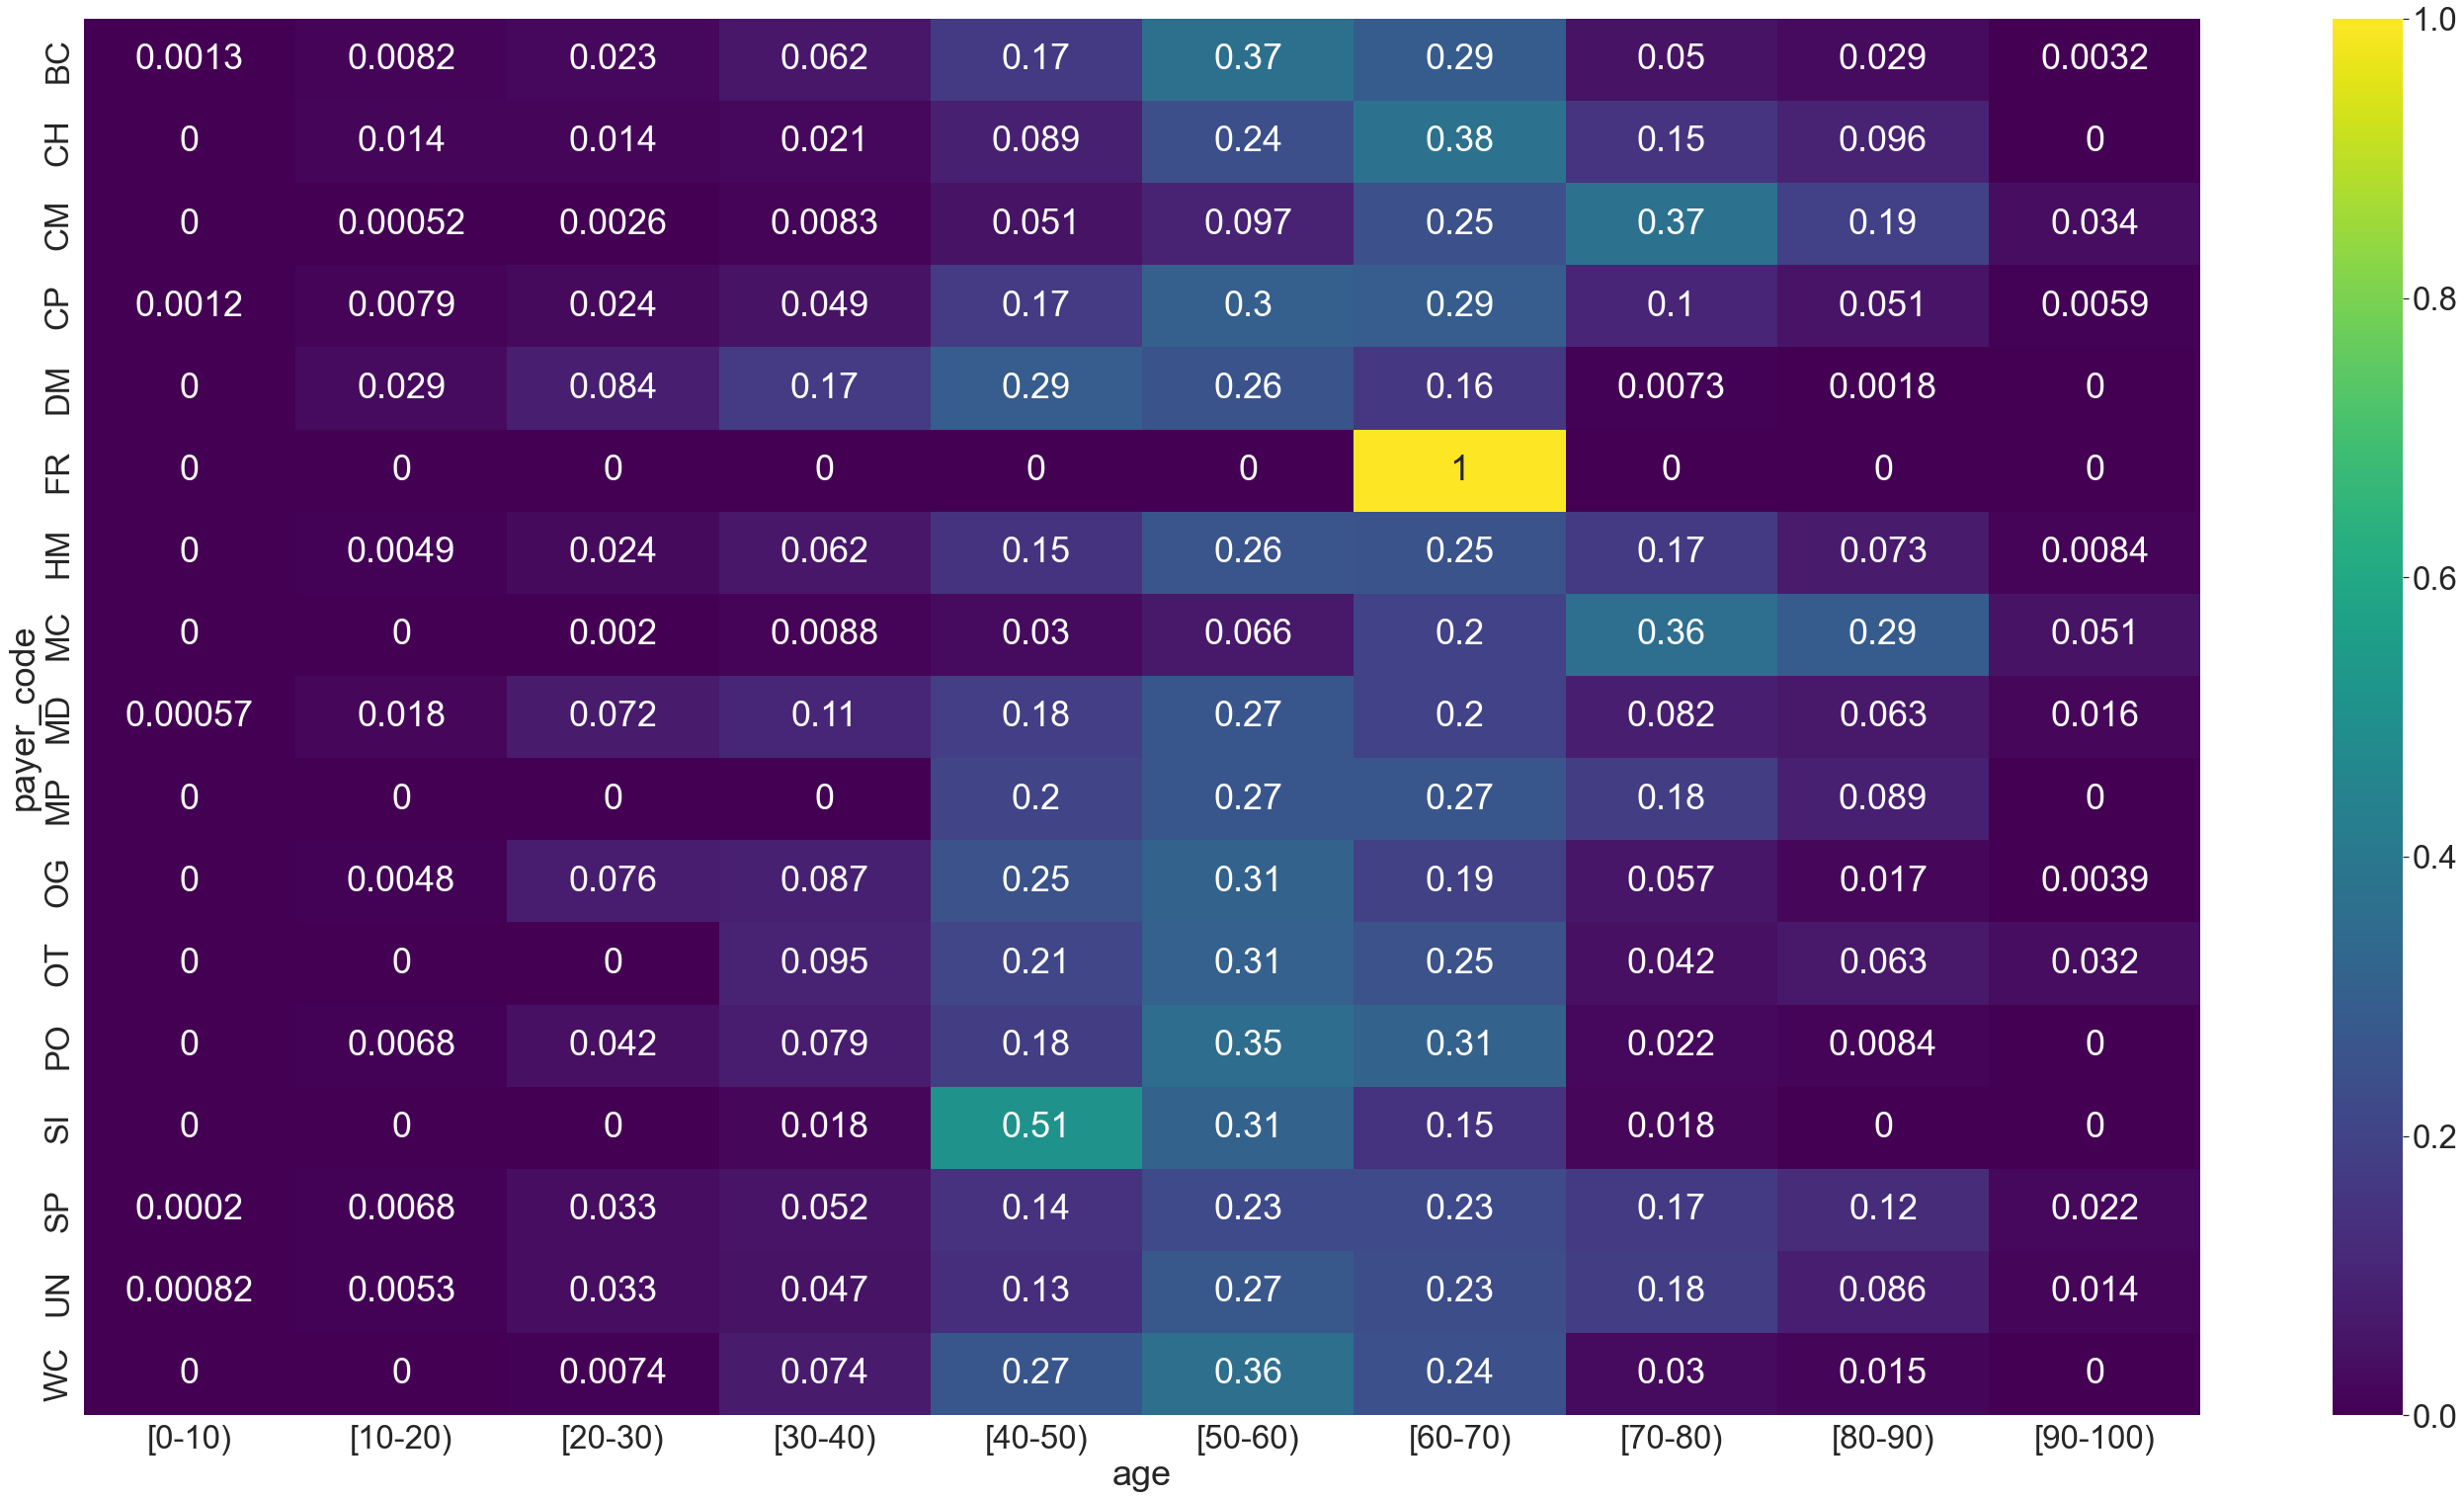

In [13]:
payer_code_vs_age = pd.DataFrame(pd.crosstab(df['payer_code'], df['age'], normalize='index'))

plt.figure(figsize=(48,26))
sns.set(font_scale=3)
sns.heatmap(payer_code_vs_age,annot=True,cmap='viridis')

There is no strong correlation relationship between each value of **payer_code** and age.  It will not be reasonable to use age to help imputing the missing values for the column.

To impute the missing value with the most occurance count which is 'MC' is also not reasonable.  There is 32,439 'MC' appears in the columns which is less than the missing values of 40,256.

The team decided to fill the **payer_code** with 'NA' to preserve the existing values.

In [14]:
df_impute.payer_code = df_impute.payer_code.fillna('NA')

#### **race**

First, let's look at the count for each value in the column.

In [15]:
print(df['race'].value_counts())

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64


Evenif, **race** has the strongest correlation at 0.125 with age, the missing values for **race** are not disproportionately from range of age, or even other category value.

The team decided to fill in the **race** NaN's with a new category of 'Not Identify'.

In [16]:
df_impute.race = df_impute.race.fillna('Not Identify')

#### **diag_1, diag_1, and diag_3**

**diag_1, diag_1, and diag_3** are correlated with each other at about *only* 0.09 - 0.11 and do not have strong correlation with any other variables in the dataset.

The team decided to fill the **diag_1, diag_1, and diag_3** with 'NA' to preserve the existing values.

In [17]:
df_impute.diag_1 = df_impute.diag_1.fillna('NA')
df_impute.diag_2 = df_impute.diag_2.fillna('NA')
df_impute.diag_3 = df_impute.diag_3.fillna('NA')

In [18]:
df_impute.head(5)

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,NA,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,NA,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,NA,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,NA,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,NA,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Model Preperations

### Target Variable - **readmitted**

There are 3 unique values in the **readmitted** target variable as shown below:

In [19]:
df_impute['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

Our objective is to predict if a patient will re-admit at the hospital within 30 days of the initial admitted. Let's change all values with '<30' to 1 for possitive case of re-admit and 0 for others values for negative case of re-admit.

In [20]:
df_model = df_impute

binary_target = {
        'NO':0,
        '>30':0,
        '<30':1
}

df_model["readmitted"] = df_model["readmitted"].map(binary_target)
df_model["readmitted"].value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

### Categorical Variables

Let's look at our categorical variables again to see if some variables needed to be adjust before applying one-hot-coding.

In [21]:
df_object = df_model.select_dtypes(include=['object_'])
df_object.describe().transpose()

,count,unique,top,freq
race,101766,6,Caucasian,76099
gender,101766,3,Female,54708
age,101766,10,[70-80),26068
payer_code,101766,18,NA,40256
medical_specialty,101766,73,NA,49949
diag_1,101766,717,428,6862
diag_2,101766,749,276,6752
diag_3,101766,790,250,11555
max_glu_serum,101766,4,None,96420
A1Cresult,101766,4,None,84748


**medical_specialty, diag_1, diag_1, and diag_3** has 73, 717, 749, and 790 unique values, respectively. These will be complicated for Logistic Regression model that the team planned to use for this prediction.

Therefore, to reduce the complication of one-hot-coding, we groupped the values in each column that appear <1% of the dataset (1,018 records) as 'Others'. 

In [22]:
def major(cols):
    x = df_model.groupby(by=cols, as_index=False).agg({'encounter_id': pd.Series.nunique})
    x.rename(columns={x.columns[0]: 'val', x.columns[1]: 'count'}, inplace = True)
    x['percent_appears'] = x['count']/df_model.shape[0]
    x = x[x['percent_appears'] > .01]
    row_to_list = x['val'].to_list()
    return row_to_list

medical_specialty_major = major(df_model['medical_specialty'])
df_model['medical_specialty_reduced'] = np.where(~df_model['medical_specialty'].isin(medical_specialty_major), "Others", df_model['medical_specialty'])
df_model.drop(columns=['medical_specialty'], axis=1, inplace=True)

diag1_major = major(df_model['diag_1'])
df_model['diag_1_reduced'] = np.where(~df_model['diag_1'].isin(diag1_major), "Others", df_model['diag_1'])
df_model.drop(columns=['diag_1'], axis=1, inplace=True)

diag2_major = major(df_model['diag_2'])
df_model['diag_2_reduced'] = np.where(~df_model['diag_2'].isin(diag2_major), "Others", df_model['diag_2'])
df_model.drop(columns=['diag_2'], axis=1, inplace=True)

diag3_major = major(df_model['diag_3'])
df_model['diag_3_reduced'] = np.where(~df_model['diag_3'].isin(diag3_major), "Others", df_model['diag_3'])
df_model.drop(columns=['diag_3'], axis=1, inplace=True)

In [23]:
df_model.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,medical_specialty_reduced,diag_1_reduced,diag_2_reduced,diag_3_reduced
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,NA,...,No,No,No,No,No,0,Others,Others,Others,NA
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,NA,...,No,No,No,Ch,Yes,0,NA,276,250.01,Others
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,NA,...,No,No,No,No,Yes,0,NA,Others,250,Others
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,NA,...,No,No,No,Ch,Yes,0,NA,Others,Others,403
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,NA,...,No,No,No,Ch,Yes,0,NA,Others,Others,250


## One-hot Encode
One-hot encode categorical variables then drop originals.

In [24]:
df_object = df_model.select_dtypes(include=['object_'])

Categoricals_to_convert = list(df_object)

# using pd get dummies for the category columns we are keeping
dummies = pd.get_dummies(df_model[Categoricals_to_convert],drop_first=True)

#dropping original columns
df_model = df_model.drop(Categoricals_to_convert,axis=1)

#concating dummies to the data frame
df_model = pd.concat([df_model,dummies],axis=1)

df_model.head()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,diag_3_reduced_427,diag_3_reduced_428,diag_3_reduced_496,diag_3_reduced_585,diag_3_reduced_599,diag_3_reduced_707,diag_3_reduced_780,diag_3_reduced_NA,diag_3_reduced_Others,diag_3_reduced_V45
0,2278392,8222157,6,25,1,1,41,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,149190,55629189,1,1,7,3,59,0,18,0,...,0,0,0,0,0,0,0,0,1,0
2,64410,86047875,1,1,7,2,11,5,13,2,...,0,0,0,0,0,0,0,0,1,0
3,500364,82442376,1,1,7,2,44,1,16,0,...,0,0,0,0,0,0,0,0,0,0
4,16680,42519267,1,1,7,1,51,0,8,0,...,0,0,0,0,0,0,0,0,0,0


# Model

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)

for train_index, test_valid_index in split.split(df_model, df_model.readmitted):
    host_modeling = df_model.iloc[train_index]
    host_validation = df_model.iloc[test_valid_index]

In [26]:
print("Size of modeling set (to be CV split): ", host_modeling.shape)
print("Size of hold back validation set: ", host_validation.shape)

Size of modeling set (to be CV split):  (91589, 180)
Size of hold back validation set:  (10177, 180)


In [28]:
#Create new X predictor matrix
X_host = host_modeling.drop(['readmitted'],axis=1).values #droping target
y_host = host_modeling['readmitted'].values
y_host = y_host.astype(int)

#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X_host)
X_host = scl_obj.transform(X_host)

In [29]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold


num_cv_iterations = 5 #Change to 10 fold for final optimization (longer compute time)
#num_instances = len(y_host)
cv_object = StratifiedKFold(n_splits=num_cv_iterations, shuffle=True, random_state=27)

In [30]:
#Create new X predictor matrix
X_host_validate = host_validation.drop(['readmitted'],axis=1).values #droping target
y_host_validate = host_validation['readmitted'].values
y_host_validate = y_host_validate.astype(int)

#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X_host_validate)
X_host_validate = scl_obj.transform(X_host_validate)

In [31]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

scorer = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average = 'macro'),
    'recall': make_scorer(recall_score, average = 'macro')
}

In [33]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

#lr does not have weights applied
lr = LogisticRegression(penalty='l1', C=1, class_weight=None, solver='saga', max_iter=100) # get object

cv_results = sklearn.model_selection.cross_validate(lr, X_host, y_host, cv=cv_object, scoring=scorer, error_score="raise") #lr does not have weights applied
print(cv_results)
print("Mean Accuracy = ",cv_results['test_accuracy'].mean())
print("Mean Precision = ",cv_results['test_precision'].mean())
print("Mean Recall = ",cv_results['test_recall'].mean())


/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'fit_time': array([14.44537997, 14.59865499, 15.30871582, 14.45904994, 14.50667214]), 'score_time': array([0.01161599, 0.00983596, 0.00995493, 0.01188707, 0.01158571]), 'test_accuracy': array([0.88841577, 0.88797904, 0.88874331, 0.88776067, 0.88846427]), 'test_precision': array([0.69486744, 0.66249982, 0.72076897, 0.65713556, 0.6989658 ]), 'test_recall': array([0.50663073, 0.50552936, 0.50702897, 0.50628898, 0.5066614 ])}
Mean Accuracy =  0.888272611248697
Mean Precision =  0.686847519688002
Mean Recall =  0.5064278879880899


/Users/puri/opt/anaconda3/envs/pyri/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
